# Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import lightgbm as lgb


from datetime import datetime

from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold


from sklearn.feature_selection import SelectFromModel

# Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [4]:
test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


# Feature Engineering

- Add new feature

In [5]:
def create_features(df):
    """
    与えられたデータフレームに対して特徴量エンジニアリングを行う関数。

    Args:
    df (DataFrame): 特徴量エンジニアリングを行うデータフレーム

    Returns:
    DataFrame: 新しい特徴量が追加されたデータフレーム
    """
    # キルとデスの比率
    df['killDeathRatio'] = df['blueKills'] / (df['blueDeaths'] + 1)  # ゼロ除算を防ぐために+1

    # アシストの割合
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)

    # ヘラルドの討伐数
    df['blueHerald'] = df['blueEliteMonsters'] - df['blueDragons']
    # blueHerald列の負の値を0で置き換え
    df['blueHerald'] = df['blueHerald'].clip(lower=0)

    # ゴールドと経験値の対数変換
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])

    # 初期キルの影響
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    
    # キル、デス、アシストの合計
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    # キル・デス・アシスト比率
    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    # チームの総合力
    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']

    return df

- Apply data

In [6]:
train = create_features(train)
test = create_features(test)

# 特徴量の効き

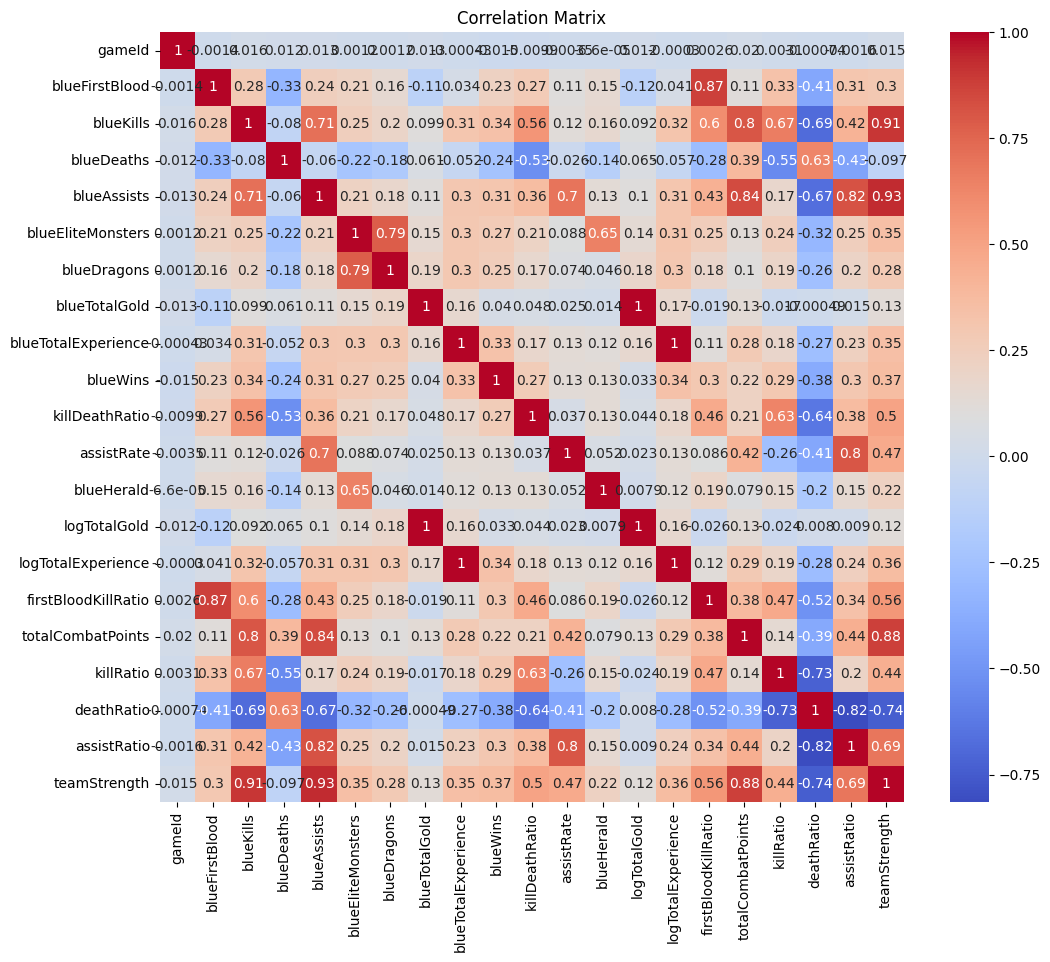

In [7]:
# 特徴量間の相関を観察
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# model

- LightGBM

[I 2024-01-19 16:45:32,974] A new study created in memory with name: no-name-1059d00f-64d4-4ba6-8a41-32e924d5d9f8


[I 2024-01-19 16:45:33,146] Trial 0 finished with value: 0.79625 and parameters: {'lambda_l1': 0.24562791749202156, 'lambda_l2': 0.2373064411179833, 'num_leaves': 171, 'feature_fraction': 0.8487555851461785, 'bagging_fraction': 0.4196750739389239, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 0 with value: 0.79625.
[I 2024-01-19 16:45:33,197] Trial 1 finished with value: 0.800625 and parameters: {'lambda_l1': 1.6184887982133257e-06, 'lambda_l2': 0.02584751967642093, 'num_leaves': 21, 'feature_fraction': 0.9260815130785627, 'bagging_fraction': 0.5727380915357801, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 1 with value: 0.800625.
[I 2024-01-19 16:45:33,252] Trial 2 finished with value: 0.795625 and parameters: {'lambda_l1': 8.582461759885247e-06, 'lambda_l2': 9.153224936642106e-07, 'num_leaves': 80, 'feature_fraction': 0.5189839410332753, 'bagging_fraction': 0.6004640125796132, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 1 with value: 0.800625.

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_error: 0.20375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.204375


[I 2024-01-19 16:45:33,420] Trial 3 finished with value: 0.798125 and parameters: {'lambda_l1': 0.21797884888472585, 'lambda_l2': 0.00018488493222651757, 'num_leaves': 255, 'feature_fraction': 0.5880491053110678, 'bagging_fraction': 0.7775255954973668, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 1 with value: 0.800625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.201875
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:33,557] Trial 4 finished with value: 0.794375 and parameters: {'lambda_l1': 8.949142817439758e-05, 'lambda_l2': 9.961985397494924e-07, 'num_leaves': 93, 'feature_fraction': 0.5351134411821762, 'bagging_fraction': 0.6039579137380171, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 1 with value: 0.800625.
[I 2024-01-19 16:45:33,636] Trial 5 finished with value: 0.79625 and parameters: {'lambda_l1': 2.437804824790164e-06, 'lambda_l2': 0.039411239674598496, 'num_leaves': 244, 'feature_fraction': 0.7355635144271038, 'bagging_fraction': 0.7977332805503345, 'bagging_freq': 5, 'min_child_samples': 85}. Best is trial 1 with value: 0.800625.
[I 2024-01-19 16:45:33,687] Trial 6 finished with value: 0.789375 and parameters: {'lambda_l1': 1.7870162191396449e-06, 'lambda_l2': 7.301044745498396e-08, 'num_leaves': 160, 'feature_fraction': 0.618231733746708, 'bagging_fraction': 0.43487948446407554, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 1 with value: 0

Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.205625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.20375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.210625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.20125


[I 2024-01-19 16:45:33,743] Trial 7 finished with value: 0.79875 and parameters: {'lambda_l1': 0.0012747590554941883, 'lambda_l2': 3.2330509213669768e-06, 'num_leaves': 81, 'feature_fraction': 0.6046797911132201, 'bagging_fraction': 0.6640798111583817, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 1 with value: 0.800625.
[I 2024-01-19 16:45:33,773] Trial 8 finished with value: 0.79 and parameters: {'lambda_l1': 0.002655171738373129, 'lambda_l2': 0.00012146140739359105, 'num_leaves': 111, 'feature_fraction': 0.41828896783371844, 'bagging_fraction': 0.5881989232755996, 'bagging_freq': 3, 'min_child_samples': 92}. Best is trial 1 with value: 0.800625.
[I 2024-01-19 16:45:33,839] Trial 9 finished with value: 0.798125 and parameters: {'lambda_l1': 0.001915377863107748, 'lambda_l2': 2.5800425230241858e-08, 'num_leaves': 40, 'feature_fraction': 0.5140099946169309, 'bagging_fraction': 0.8214244818277285, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 1 with value: 0.80

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.21
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.201875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_error: 0.24
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:33,984] Trial 11 finished with value: 0.800625 and parameters: {'lambda_l1': 1.7063557075362157e-08, 'lambda_l2': 0.00211002388705817, 'num_leaves': 43, 'feature_fraction': 0.7477074427613033, 'bagging_fraction': 0.6686328943758064, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 1 with value: 0.800625.
[I 2024-01-19 16:45:34,066] Trial 12 finished with value: 0.773125 and parameters: {'lambda_l1': 1.2290064426849269e-08, 'lambda_l2': 0.006784843142332914, 'num_leaves': 7, 'feature_fraction': 0.8090008613085715, 'bagging_fraction': 0.538629130832114, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 1 with value: 0.800625.
[I 2024-01-19 16:45:34,153] Trial 13 finished with value: 0.803125 and parameters: {'lambda_l1': 1.386756115867153e-07, 'lambda_l2': 0.0030994483783142925, 'num_leaves': 51, 'feature_fraction': 0.936982582143466, 'bagging_fraction': 0.7110423954848559, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 13 with value: 0.

Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.226875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.196875


[I 2024-01-19 16:45:34,268] Trial 14 finished with value: 0.803125 and parameters: {'lambda_l1': 1.0057575251970618e-07, 'lambda_l2': 0.0014448014631685876, 'num_leaves': 48, 'feature_fraction': 0.9953824716675195, 'bagging_fraction': 0.7184322963982124, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 13 with value: 0.803125.
[I 2024-01-19 16:45:34,384] Trial 15 finished with value: 0.795625 and parameters: {'lambda_l1': 1.6243196378243205e-07, 'lambda_l2': 0.00047473982154268095, 'num_leaves': 54, 'feature_fraction': 0.9806274129648048, 'bagging_fraction': 0.7392992280687259, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 13 with value: 0.803125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.204375


[I 2024-01-19 16:45:34,521] Trial 16 finished with value: 0.8025 and parameters: {'lambda_l1': 1.914485607539607e-07, 'lambda_l2': 2.549732098595621e-05, 'num_leaves': 151, 'feature_fraction': 0.8989916761890323, 'bagging_fraction': 0.9693195969879833, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 13 with value: 0.803125.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:34,789] Trial 17 finished with value: 0.790625 and parameters: {'lambda_l1': 1.4586490417878667e-07, 'lambda_l2': 0.0010140050045139575, 'num_leaves': 125, 'feature_fraction': 0.9991559341347174, 'bagging_fraction': 0.8571426984105046, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 13 with value: 0.803125.
[I 2024-01-19 16:45:34,905] Trial 18 finished with value: 0.808125 and parameters: {'lambda_l1': 4.011166098812112e-05, 'lambda_l2': 3.3313129546124646e-05, 'num_leaves': 207, 'feature_fraction': 0.9072175007288168, 'bagging_fraction': 0.7216884778970216, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 18 with value: 0.808125.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.209375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:35,083] Trial 19 finished with value: 0.801875 and parameters: {'lambda_l1': 3.680850975971931e-05, 'lambda_l2': 6.171606489719695e-05, 'num_leaves': 210, 'feature_fraction': 0.8377319249966017, 'bagging_fraction': 0.7399307740982602, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 18 with value: 0.808125.
[I 2024-01-19 16:45:35,187] Trial 20 finished with value: 0.8 and parameters: {'lambda_l1': 0.0001434709195227193, 'lambda_l2': 1.1176909810655934e-05, 'num_leaves': 202, 'feature_fraction': 0.907940632095782, 'bagging_fraction': 0.6686960258341396, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 18 with value: 0.808125.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:35,339] Trial 21 finished with value: 0.80375 and parameters: {'lambda_l1': 6.854373413641112e-07, 'lambda_l2': 0.0006678239248622334, 'num_leaves': 73, 'feature_fraction': 0.9437299700381074, 'bagging_fraction': 0.7238856347904058, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 18 with value: 0.808125.
[I 2024-01-19 16:45:35,462] Trial 22 finished with value: 0.804375 and parameters: {'lambda_l1': 1.2716280670289017e-05, 'lambda_l2': 0.00020606629809964236, 'num_leaves': 67, 'feature_fraction': 0.9312967031335893, 'bagging_fraction': 0.7571363720472747, 'bagging_freq': 5, 'min_child_samples': 45}. Best is trial 18 with value: 0.808125.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:35,625] Trial 23 finished with value: 0.801875 and parameters: {'lambda_l1': 1.5715044871829913e-05, 'lambda_l2': 0.00020915977854338272, 'num_leaves': 95, 'feature_fraction': 0.8728078085235406, 'bagging_fraction': 0.7846976376859185, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 18 with value: 0.808125.
[I 2024-01-19 16:45:35,724] Trial 24 finished with value: 0.8025 and parameters: {'lambda_l1': 5.072320281014211e-06, 'lambda_l2': 6.005516806900477e-05, 'num_leaves': 134, 'feature_fraction': 0.7801720801661092, 'bagging_fraction': 0.8624754621100621, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 18 with value: 0.808125.


Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:35,838] Trial 25 finished with value: 0.803125 and parameters: {'lambda_l1': 8.445120132615164e-07, 'lambda_l2': 1.158313259918105e-05, 'num_leaves': 197, 'feature_fraction': 0.8661140275897398, 'bagging_fraction': 0.7588379850682792, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 18 with value: 0.808125.
[I 2024-01-19 16:45:35,969] Trial 26 finished with value: 0.804375 and parameters: {'lambda_l1': 2.920844476510719e-05, 'lambda_l2': 0.0003371946714475367, 'num_leaves': 68, 'feature_fraction': 0.9435451713246364, 'bagging_fraction': 0.6976716404909289, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 18 with value: 0.808125.


Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:36,071] Trial 27 finished with value: 0.80625 and parameters: {'lambda_l1': 2.388379746377199e-05, 'lambda_l2': 3.2173926056706957e-05, 'num_leaves': 105, 'feature_fraction': 0.8104172707500988, 'bagging_fraction': 0.673124529148824, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 18 with value: 0.808125.
[I 2024-01-19 16:45:36,168] Trial 28 finished with value: 0.79625 and parameters: {'lambda_l1': 0.00032754216300279345, 'lambda_l2': 2.3800745594294305e-05, 'num_leaves': 229, 'feature_fraction': 0.8172524855245198, 'bagging_fraction': 0.6406994501230853, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 18 with value: 0.808125.


Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.20375
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:36,333] Trial 29 finished with value: 0.8025 and parameters: {'lambda_l1': 1.04201436999e-05, 'lambda_l2': 2.754665356583669e-06, 'num_leaves': 176, 'feature_fraction': 0.8810543041053637, 'bagging_fraction': 0.8195945020345634, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 18 with value: 0.808125.
[I 2024-01-19 16:45:36,454] Trial 30 finished with value: 0.809375 and parameters: {'lambda_l1': 8.282411403392312e-05, 'lambda_l2': 5.849851956865116e-05, 'num_leaves': 115, 'feature_fraction': 0.8416627791620381, 'bagging_fraction': 0.7607170042219766, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 30 with value: 0.809375.


Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.190625


[I 2024-01-19 16:45:36,637] Trial 31 finished with value: 0.801875 and parameters: {'lambda_l1': 6.209276786257154e-05, 'lambda_l2': 0.00010119735715998087, 'num_leaves': 115, 'feature_fraction': 0.8443074010007261, 'bagging_fraction': 0.746772343657991, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 30 with value: 0.809375.
[I 2024-01-19 16:45:36,750] Trial 32 finished with value: 0.805 and parameters: {'lambda_l1': 0.00027894425300146173, 'lambda_l2': 1.970100074185157e-05, 'num_leaves': 140, 'feature_fraction': 0.7798028890290364, 'bagging_fraction': 0.7669978490717884, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 30 with value: 0.809375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.195


[I 2024-01-19 16:45:36,875] Trial 33 finished with value: 0.801875 and parameters: {'lambda_l1': 0.00025223393221252764, 'lambda_l2': 5.739445118829352e-06, 'num_leaves': 146, 'feature_fraction': 0.7840323641050607, 'bagging_fraction': 0.6935706045303083, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 30 with value: 0.809375.
[I 2024-01-19 16:45:37,010] Trial 34 finished with value: 0.801875 and parameters: {'lambda_l1': 0.0003826785594770442, 'lambda_l2': 2.7547678548925455e-05, 'num_leaves': 178, 'feature_fraction': 0.849869223577294, 'bagging_fraction': 0.6435728329760668, 'bagging_freq': 2, 'min_child_samples': 52}. Best is trial 30 with value: 0.809375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.198125


[I 2024-01-19 16:45:37,124] Trial 35 finished with value: 0.80375 and parameters: {'lambda_l1': 0.006188242605926158, 'lambda_l2': 5.870825052889065e-07, 'num_leaves': 96, 'feature_fraction': 0.8043886986595873, 'bagging_fraction': 0.7782658454881257, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 30 with value: 0.809375.
[I 2024-01-19 16:45:37,235] Trial 36 finished with value: 0.79875 and parameters: {'lambda_l1': 5.7175033849675396e-05, 'lambda_l2': 6.938200292848816e-07, 'num_leaves': 139, 'feature_fraction': 0.7008734435211376, 'bagging_fraction': 0.8076611523156538, 'bagging_freq': 2, 'min_child_samples': 77}. Best is trial 30 with value: 0.809375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.20125


[I 2024-01-19 16:45:37,392] Trial 37 finished with value: 0.80375 and parameters: {'lambda_l1': 4.105165866550807e-06, 'lambda_l2': 5.741699889013208e-05, 'num_leaves': 116, 'feature_fraction': 0.759976971455567, 'bagging_fraction': 0.6947553386112352, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 30 with value: 0.809375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.199375


[I 2024-01-19 16:45:37,515] Trial 38 finished with value: 0.800625 and parameters: {'lambda_l1': 0.00974456613606941, 'lambda_l2': 2.4022422383140643e-06, 'num_leaves': 227, 'feature_fraction': 0.8349703215823413, 'bagging_fraction': 0.6182044066300793, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 30 with value: 0.809375.
[I 2024-01-19 16:45:37,624] Trial 39 finished with value: 0.805 and parameters: {'lambda_l1': 2.0744325058191234e-05, 'lambda_l2': 1.069394285173402e-05, 'num_leaves': 158, 'feature_fraction': 0.7160086443049963, 'bagging_fraction': 0.5617818019752235, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 30 with value: 0.809375.
[I 2024-01-19 16:45:37,720] Trial 40 finished with value: 0.80625 and parameters: {'lambda_l1': 0.0006451571190392708, 'lambda_l2': 0.0003766676705027726, 'num_leaves': 166, 'feature_fraction': 0.6684885306292446, 'bagging_fraction': 0.7659673834843185, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 30 with valu

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:37,834] Trial 41 finished with value: 0.805 and parameters: {'lambda_l1': 0.0007193475724540134, 'lambda_l2': 0.0003051654141560157, 'num_leaves': 169, 'feature_fraction': 0.6618662839162599, 'bagging_fraction': 0.7655516952022942, 'bagging_freq': 5, 'min_child_samples': 60}. Best is trial 30 with value: 0.809375.
[I 2024-01-19 16:45:37,969] Trial 42 finished with value: 0.81 and parameters: {'lambda_l1': 0.00012574523309452417, 'lambda_l2': 9.369271468387692e-05, 'num_leaves': 195, 'feature_fraction': 0.7250899668297064, 'bagging_fraction': 0.7956437638045937, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_error: 0.19


[I 2024-01-19 16:45:38,128] Trial 43 finished with value: 0.7925 and parameters: {'lambda_l1': 0.0001285962170333196, 'lambda_l2': 0.00010849005421081127, 'num_leaves': 195, 'feature_fraction': 0.6758961639596593, 'bagging_fraction': 0.7982561658919911, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.2075
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:38,280] Trial 44 finished with value: 0.8025 and parameters: {'lambda_l1': 4.704281926192531e-05, 'lambda_l2': 4.5457685387657885e-05, 'num_leaves': 182, 'feature_fraction': 0.7056427642286364, 'bagging_fraction': 0.8322306540726637, 'bagging_freq': 5, 'min_child_samples': 67}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:38,457] Trial 45 finished with value: 0.79625 and parameters: {'lambda_l1': 0.00011202179623274474, 'lambda_l2': 0.0008622223210393518, 'num_leaves': 253, 'feature_fraction': 0.7447632657994391, 'bagging_fraction': 0.7252637095546385, 'bagging_freq': 5, 'min_child_samples': 97}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.20375


[I 2024-01-19 16:45:38,613] Trial 46 finished with value: 0.795 and parameters: {'lambda_l1': 0.0009531804780202549, 'lambda_l2': 0.0035557436595556563, 'num_leaves': 223, 'feature_fraction': 0.6480527289947661, 'bagging_fraction': 0.7832910305846997, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:38,740] Trial 47 finished with value: 0.805625 and parameters: {'lambda_l1': 8.451371466282382e-06, 'lambda_l2': 0.0002056597204501719, 'num_leaves': 189, 'feature_fraction': 0.722824157253714, 'bagging_fraction': 0.6905753848691271, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.205
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.194375


[I 2024-01-19 16:45:38,863] Trial 48 finished with value: 0.803125 and parameters: {'lambda_l1': 0.002884983166418716, 'lambda_l2': 0.021774681006353463, 'num_leaves': 216, 'feature_fraction': 0.7539773708810344, 'bagging_fraction': 0.7310280020834676, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:38,977] Trial 49 finished with value: 0.80125 and parameters: {'lambda_l1': 2.4924316134814755e-05, 'lambda_l2': 0.0005440276983374028, 'num_leaves': 159, 'feature_fraction': 0.8103389125239683, 'bagging_fraction': 0.8357040074765142, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.19875


[I 2024-01-19 16:45:39,196] Trial 50 finished with value: 0.8025 and parameters: {'lambda_l1': 3.676928632077389e-06, 'lambda_l2': 0.00010941220110970525, 'num_leaves': 109, 'feature_fraction': 0.7291119399272881, 'bagging_fraction': 0.7963667889386221, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.1975


[I 2024-01-19 16:45:39,350] Trial 51 finished with value: 0.803125 and parameters: {'lambda_l1': 6.566982139433234e-06, 'lambda_l2': 0.00019914241134440068, 'num_leaves': 188, 'feature_fraction': 0.6891081606331445, 'bagging_fraction': 0.7169132005477591, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.195625


[I 2024-01-19 16:45:39,471] Trial 52 finished with value: 0.804375 and parameters: {'lambda_l1': 6.220552619125957e-05, 'lambda_l2': 0.00141931882080825, 'num_leaves': 204, 'feature_fraction': 0.7205021476304467, 'bagging_fraction': 0.6824816154059804, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:39,656] Trial 53 finished with value: 0.80375 and parameters: {'lambda_l1': 1.6948994164705597e-06, 'lambda_l2': 3.987579120598792e-05, 'num_leaves': 167, 'feature_fraction': 0.6169666711551299, 'bagging_fraction': 0.7056126009790865, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:39,760] Trial 54 finished with value: 0.7975 and parameters: {'lambda_l1': 7.361576158151444e-06, 'lambda_l2': 0.0004536272277222926, 'num_leaves': 189, 'feature_fraction': 0.6410985452956441, 'bagging_fraction': 0.673478509938866, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.2025


[I 2024-01-19 16:45:39,956] Trial 55 finished with value: 0.7925 and parameters: {'lambda_l1': 0.00014430620312590048, 'lambda_l2': 0.00012673209545107137, 'num_leaves': 236, 'feature_fraction': 0.7319086420430121, 'bagging_fraction': 0.7504548566641123, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.2075
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:40,092] Trial 56 finished with value: 0.8075 and parameters: {'lambda_l1': 1.5103221136440466e-05, 'lambda_l2': 0.00030045628557234864, 'num_leaves': 127, 'feature_fraction': 0.6879152964513731, 'bagging_fraction': 0.6535196774231005, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:40,197] Trial 57 finished with value: 0.8025 and parameters: {'lambda_l1': 2.4341419477980034e-05, 'lambda_l2': 0.0016906705873865465, 'num_leaves': 124, 'feature_fraction': 0.6788900182973883, 'bagging_fraction': 0.6422893483059727, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:40,287] Trial 58 finished with value: 0.79625 and parameters: {'lambda_l1': 8.69278717766553e-05, 'lambda_l2': 7.910475341129995e-05, 'num_leaves': 104, 'feature_fraction': 0.5756525803672267, 'bagging_fraction': 0.7357154379511108, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 42 with value: 0.81

Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_error: 0.20375


[I 2024-01-19 16:45:40,402] Trial 59 finished with value: 0.801875 and parameters: {'lambda_l1': 0.0004723405489306324, 'lambda_l2': 0.0008630281943432557, 'num_leaves': 127, 'feature_fraction': 0.9046682525937537, 'bagging_fraction': 0.7132584608287477, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:40,546] Trial 60 finished with value: 0.80625 and parameters: {'lambda_l1': 3.4153942606309565e-05, 'lambda_l2': 1.6702332328699628e-05, 'num_leaves': 92, 'feature_fraction': 0.695965842183635, 'bagging_fraction': 0.7731772124688183, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.19375


[I 2024-01-19 16:45:40,665] Trial 61 finished with value: 0.804375 and parameters: {'lambda_l1': 1.3452015684761853e-05, 'lambda_l2': 1.549527621920728e-05, 'num_leaves': 82, 'feature_fraction': 0.6894274505202701, 'bagging_fraction': 0.7653593606822283, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:40,780] Trial 62 finished with value: 0.80375 and parameters: {'lambda_l1': 3.914780837175687e-05, 'lambda_l2': 3.5676635716686685e-05, 'num_leaves': 101, 'feature_fraction': 0.6628550339382869, 'bagging_fraction': 0.6635739839682289, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.19625


[I 2024-01-19 16:45:40,923] Trial 63 finished with value: 0.805 and parameters: {'lambda_l1': 0.00018276335818817282, 'lambda_l2': 5.8892104198819875e-06, 'num_leaves': 87, 'feature_fraction': 0.7642545167274569, 'bagging_fraction': 0.7460426785980946, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:41,043] Trial 64 finished with value: 0.80625 and parameters: {'lambda_l1': 9.009348609494443e-05, 'lambda_l2': 0.00035371138247884, 'num_leaves': 119, 'feature_fraction': 0.7031150966445123, 'bagging_fraction': 0.7835943618334088, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.19375


[I 2024-01-19 16:45:41,277] Trial 65 finished with value: 0.808125 and parameters: {'lambda_l1': 1.582130320330185e-05, 'lambda_l2': 7.093673863618665e-05, 'num_leaves': 59, 'feature_fraction': 0.7405466869088445, 'bagging_fraction': 0.8056304133233321, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.191875


[I 2024-01-19 16:45:41,415] Trial 66 finished with value: 0.799375 and parameters: {'lambda_l1': 2.6653969390426667e-06, 'lambda_l2': 6.604388108088402e-05, 'num_leaves': 28, 'feature_fraction': 0.7926211415939712, 'bagging_fraction': 0.8083075162895411, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:41,517] Trial 67 finished with value: 0.794375 and parameters: {'lambda_l1': 1.1337606175857178e-05, 'lambda_l2': 0.00017016714126083884, 'num_leaves': 15, 'feature_fraction': 0.7667770169710405, 'bagging_fraction': 0.7324132201055218, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.200625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.205625


[I 2024-01-19 16:45:41,682] Trial 68 finished with value: 0.806875 and parameters: {'lambda_l1': 1.702345861805612e-05, 'lambda_l2': 5.159582340379556e-05, 'num_leaves': 146, 'feature_fraction': 0.7371125087789084, 'bagging_fraction': 0.8493162659160257, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:41,905] Trial 69 finished with value: 0.805 and parameters: {'lambda_l1': 2.0012837825854407e-05, 'lambda_l2': 2.810629358746626e-05, 'num_leaves': 150, 'feature_fraction': 0.7427090879943888, 'bagging_fraction': 0.8733436197999115, 'bagging_freq': 3, 'min_child_samples': 23}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:42,022] Trial 70 finished with value: 0.806875 and parameters: {'lambda_l1': 9.406191965175549e-07, 'lambda_l2': 7.229883078599229e-05, 'num_leaves': 58, 'feature_fraction': 0.8178852632746342, 'bagging_fraction': 0.6132397924874157, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:42,121] Trial 71 finished with value: 0.804375 and parameters: {'lambda_l1': 7.146057684016288e-07, 'lambda_l2': 5.3125530671913765e-05, 'num_leaves': 34, 'feature_fraction': 0.8327458670539567, 'bagging_fraction': 0.6034107127997608, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:42,233] Trial 72 finished with value: 0.803125 and parameters: {'lambda_l1': 2.6330849075918497e-06, 'lambda_l2': 0.00011627073899003298, 'num_leaves': 59, 'feature_fraction': 0.8223515972583585, 'bagging_fraction': 0.6253378582304905, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:42,337] Trial 73 finished with value: 0.8075 and parameters: {'lambda_l1': 4.89833519497117e-06, 'lambda_l2': 3.398488026484947e-05, 'num_leaves': 62, 'feature_fraction': 0.8023929848289224, 'bagging_fraction': 0.654432589448675, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:42,488] Trial 74 finished with value: 0.8 and parameters: {'lambda_l1': 1.3718353192168714e-06, 'lambda_l2': 6.910695960679676e-05, 'num_leaves': 60, 'feature_fraction': 0.7916569398432967, 'bagging_fraction': 0.5846378673762953, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.2


[I 2024-01-19 16:45:42,681] Trial 75 finished with value: 0.804375 and parameters: {'lambda_l1': 6.443546882303541e-06, 'lambda_l2': 9.08427488216117e-06, 'num_leaves': 44, 'feature_fraction': 0.8562684255984677, 'bagging_fraction': 0.6496387904263479, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:42,879] Trial 76 finished with value: 0.800625 and parameters: {'lambda_l1': 1.4824225339151844e-05, 'lambda_l2': 1.653800717210245e-05, 'num_leaves': 71, 'feature_fraction': 0.775117909873845, 'bagging_fraction': 0.6146709587282282, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:43,068] Trial 77 finished with value: 0.808125 and parameters: {'lambda_l1': 3.76344427734402e-07, 'lambda_l2': 3.127842119413469e-05, 'num_leaves': 76, 'feature_fraction': 0.7579113691459513, 'bagging_fraction': 0.8905653398894084, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.191875


[I 2024-01-19 16:45:43,211] Trial 78 finished with value: 0.8 and parameters: {'lambda_l1': 5.170784223682914e-07, 'lambda_l2': 3.0108779038700567e-05, 'num_leaves': 78, 'feature_fraction': 0.7472045394950259, 'bagging_fraction': 0.8907571909866107, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:43,452] Trial 79 finished with value: 0.805625 and parameters: {'lambda_l1': 3.7090066487124084e-06, 'lambda_l2': 7.026625019393822e-06, 'num_leaves': 136, 'feature_fraction': 0.7699558429437233, 'bagging_fraction': 0.8461091521331124, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.198125


[I 2024-01-19 16:45:43,650] Trial 80 finished with value: 0.801875 and parameters: {'lambda_l1': 5.1552780750015485e-05, 'lambda_l2': 0.0002690235884647682, 'num_leaves': 67, 'feature_fraction': 0.8893966290401467, 'bagging_fraction': 0.8208647640991463, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:43,813] Trial 81 finished with value: 0.80625 and parameters: {'lambda_l1': 1.662936456044843e-06, 'lambda_l2': 0.0001516462178992076, 'num_leaves': 56, 'feature_fraction': 0.7915072938695765, 'bagging_fraction': 0.9345021572180553, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:43,939] Trial 82 finished with value: 0.804375 and parameters: {'lambda_l1': 3.012894935218284e-07, 'lambda_l2': 8.046968098459198e-05, 'num_leaves': 37, 'feature_fraction': 0.8540237317700466, 'bagging_fraction': 0.85723718768475, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.195625


[I 2024-01-19 16:45:44,135] Trial 83 finished with value: 0.804375 and parameters: {'lambda_l1': 4.811941106148407e-06, 'lambda_l2': 4.174813722367378e-05, 'num_leaves': 47, 'feature_fraction': 0.8240912923974535, 'bagging_fraction': 0.8294000592568676, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:44,303] Trial 84 finished with value: 0.80625 and parameters: {'lambda_l1': 9.60481189372793e-06, 'lambda_l2': 2.1044519940271993e-05, 'num_leaves': 63, 'feature_fraction': 0.7539144850322178, 'bagging_fraction': 0.8457449618067325, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:44,513] Trial 85 finished with value: 0.800625 and parameters: {'lambda_l1': 1.2826465198394858e-06, 'lambda_l2': 1.3135670095292335e-05, 'num_leaves': 75, 'feature_fraction': 0.8006995740123839, 'bagging_fraction': 0.7940325751846516, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:44,665] Trial 86 finished with value: 0.8025 and parameters: {'lambda_l1': 1.5630478640893512e-05, 'lambda_l2': 0.0002352318916396229, 'num_leaves': 53, 'feature_fraction': 0.7130730960706345, 'bagging_fraction': 0.7027516564797158, 'bagging_freq': 2, 'min_child_samples': 52}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.1975


[I 2024-01-19 16:45:44,819] Trial 87 finished with value: 0.799375 and parameters: {'lambda_l1': 2.6111602408477668e-06, 'lambda_l2': 0.0006089201331959655, 'num_leaves': 83, 'feature_fraction': 0.7315057396433643, 'bagging_fraction': 0.8106705656344968, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.200625
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:44,971] Trial 88 finished with value: 0.803125 and parameters: {'lambda_l1': 2.836419573290675e-05, 'lambda_l2': 4.33623372270519e-06, 'num_leaves': 143, 'feature_fraction': 0.8677493586956522, 'bagging_fraction': 0.6573481643040774, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:45,150] Trial 89 finished with value: 0.806875 and parameters: {'lambda_l1': 0.00019663348575463436, 'lambda_l2': 5.183504308378966e-05, 'num_leaves': 215, 'feature_fraction': 0.7747371123452291, 'bagging_fraction': 0.6307455352748224, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.193125


[I 2024-01-19 16:45:45,269] Trial 90 finished with value: 0.800625 and parameters: {'lambda_l1': 4.096874360800162e-07, 'lambda_l2': 9.711896153512369e-05, 'num_leaves': 23, 'feature_fraction': 0.7417097700509887, 'bagging_fraction': 0.7542664214584571, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:45,426] Trial 91 finished with value: 0.80125 and parameters: {'lambda_l1': 6.920386191673465e-05, 'lambda_l2': 5.5416731567192004e-05, 'num_leaves': 217, 'feature_fraction': 0.7752136243008615, 'bagging_fraction': 0.6467477223969916, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.19875


[I 2024-01-19 16:45:45,593] Trial 92 finished with value: 0.80125 and parameters: {'lambda_l1': 0.00019414648544805073, 'lambda_l2': 2.248730805906732e-05, 'num_leaves': 208, 'feature_fraction': 0.814446958556832, 'bagging_fraction': 0.6259505869624232, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.19875
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:45,787] Trial 93 finished with value: 0.8075 and parameters: {'lambda_l1': 3.9589520391669064e-05, 'lambda_l2': 0.00015267766717011163, 'num_leaves': 196, 'feature_fraction': 0.7592769483347649, 'bagging_fraction': 0.6707097156897055, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:45,968] Trial 94 finished with value: 0.801875 and parameters: {'lambda_l1': 4.012894005058844e-05, 'lambda_l2': 0.00016772086574227816, 'num_leaves': 201, 'feature_fraction': 0.7178418771516002, 'bagging_fraction': 0.6697273922066905, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.198125


[I 2024-01-19 16:45:46,129] Trial 95 finished with value: 0.79875 and parameters: {'lambda_l1': 5.852942536747668e-06, 'lambda_l2': 0.0003557133100956049, 'num_leaves': 179, 'feature_fraction': 0.7572583732804402, 'bagging_fraction': 0.684768132437865, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.20125
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:46,290] Trial 96 finished with value: 0.806875 and parameters: {'lambda_l1': 9.239088948327396e-06, 'lambda_l2': 3.7220707090071756e-05, 'num_leaves': 174, 'feature_fraction': 0.7321155502068089, 'bagging_fraction': 0.7217564307323304, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 42 with value: 0.81.
[I 2024-01-19 16:45:46,454] Trial 97 finished with value: 0.799375 and parameters: {'lambda_l1': 9.680724775680148e-05, 'lambda_l2': 9.487734150680108e-06, 'num_leaves': 196, 'feature_fraction': 0.7969642493109872, 'bagging_fraction': 0.6884702665122975, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.200625


[I 2024-01-19 16:45:46,620] Trial 98 finished with value: 0.801875 and parameters: {'lambda_l1': 1.842074463776286e-05, 'lambda_l2': 8.847911822162263e-05, 'num_leaves': 131, 'feature_fraction': 0.8316231791213867, 'bagging_fraction': 0.7021708151054128, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 42 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 16:45:46,765] Trial 99 finished with value: 0.805625 and parameters: {'lambda_l1': 3.2422648546831374e-05, 'lambda_l2': 0.00013967477019157524, 'num_leaves': 236, 'feature_fraction': 0.7851251605287347, 'bagging_fraction': 0.6566611290460291, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 42 with value: 0.81.


Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.194375
Validation Accuracy with selected features: 0.79125
[1 1 1 ... 1 1 0]


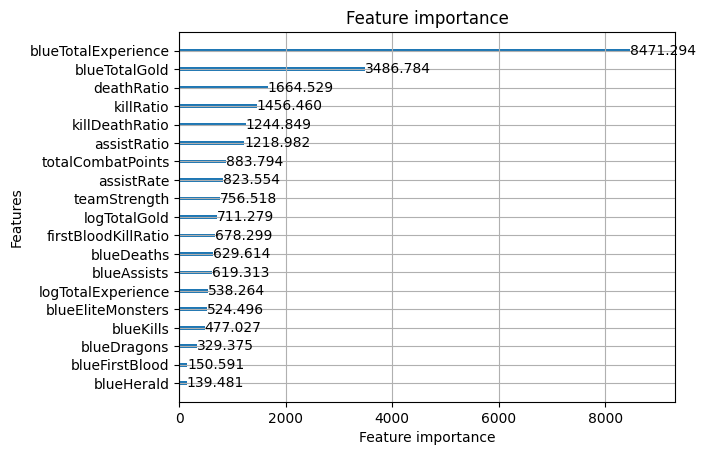

In [8]:
# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

test_drop_gameId = test.drop('gameId', axis=1)

# Optunaでのハイパーパラメータチューニング
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    verbose_eval = 0
    verbose = lgb.log_evaluation(verbose_eval)

    # 早期停止の設定
    early_stopping = lgb.early_stopping(stopping_rounds=10, verbose=True)
    model = lgb.train(param, lgb_train, num_boost_round=1000, valid_sets=[lgb_val], callbacks=[early_stopping, verbose])
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最適なハイパーパラメータでモデルを再学習
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_error'
best_params['verbosity'] = -1

lgb_model = LGBMClassifier(**best_params)

# early_stopping_roundsをコールバック関数として設定
early_stopping = lgb.early_stopping(stopping_rounds=10, verbose=False)

# モデルのトレーニング
lgb_model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_val, y_val)], 
    callbacks=[early_stopping]
)

# 選択された特徴量でモデルを再トレーニング
lgb_model.fit(X_train, y_train)

# バリデーションデータでの評価
y_val_pred = lgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy with selected features: {accuracy}')

# テストデータに対する予測
y_test_pred = lgb_model.predict(test_drop_gameId)
y_test_pred_int = (y_test_pred > 0.5).astype(int)

# 予測結果の表示
print(y_test_pred_int)

# 特徴量の重要度をプロット
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=30)
plt.show()

- 特徴量重要度可視化

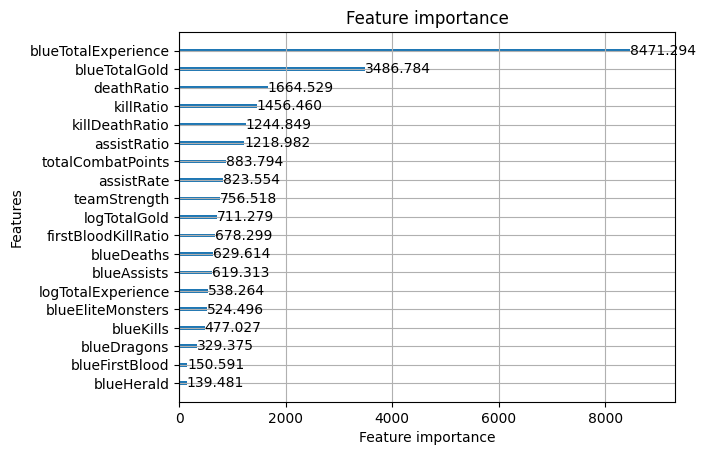

In [9]:
# 特徴量の重要度をプロット
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=30)
plt.show()

- testにy_test_pred結合

In [10]:
# 現在の日時を取得してフォーマットする
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output = f'../data/output/{current_time}_submit_cv_oputuna_val.csv'

In [11]:
submit = pd.DataFrame({
    '0': test['gameId'],
    '1': y_test_pred_int
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

- 出力csvチェック

In [12]:
check = pd.read_csv(output)

In [13]:
check

,9,1
0,15,1
1,18,1
2,23,0
3,31,0
4,32,1
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
